# **Modelo de regresión con MLP**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [49]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [50]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Función grafica mejor

In [68]:
from sklearn.neural_network import MLPRegressor

def grafica_mejor(url, opc):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

  MLPR = MLPRegressor(random_state=1, max_iter=200, hidden_layer_sizes=opc, learning_rate='adaptive', learning_rate_init=0.01)
  MLPR.fit(X_Entrenamiento, Y_Entrenamiento)

  Y_pred = MLPR.predict(X_Prueba)
  
  print(Y_pred.max())
  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión MLP') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión MLP') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

##Función de metricas

In [53]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


In [54]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);

##Medianos

In [55]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [56]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/mlp_regressor.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data
      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
        layers = [(100, 1), (100, 2)]

        for opc in layers:
          MLPR = MLPRegressor(random_state=1, max_iter=200, hidden_layer_sizes=opc, learning_rate='adaptive', learning_rate_init=0.01)
          MLPR.fit(X_Entrenamiento, Y_Entrenamiento)

          Y_pred = MLPR.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, MLPR, filename)
          result['CONFIG'] = '_'.join(str(v) for v in opc)
          df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [57]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
223,min_max_isf_400_0_2.csv,100_2,6.939605e-01,-0.000046,0.000009,0.288577,0.242406,0.702056,0.001831,0.117531,2.025766
215,min_max_isf_400_auto.csv,100_2,8.362265e-01,-0.000083,0.000035,0.242489,0.502493,0.836323,0.001961,0.033603,2.054826
213,min_max_isf_300_0_2.csv,100_2,7.036153e-01,-0.000036,0.000003,0.447683,0.213386,0.732757,0.001989,0.080320,1.839866
209,min_max_isf_300_0_1.csv,100_2,8.412787e-01,-0.000045,0.000015,0.646366,0.086313,0.854407,0.002066,0.035344,0.612263
195,min_max_isf_200_auto.csv,100_2,8.318973e-01,-0.000094,0.000015,0.236516,0.491039,0.832194,0.002096,0.062701,1.041028
191,min_max_isf_100_0_15.csv,100_2,7.935315e-01,-0.000047,0.000037,0.625288,0.368686,0.814775,0.002136,0.080176,1.095509
221,min_max_isf_400_0_15.csv,100_2,7.887023e-01,-0.000066,0.000047,0.312299,0.378229,0.789967,0.002140,0.139559,1.319247
205,min_max_isf_300_auto.csv,100_2,8.068266e-01,-0.000082,0.000012,-0.037703,0.283378,0.806981,0.002159,0.074654,1.135530
193,min_max_isf_100_0_2.csv,100_2,7.380107e-01,-0.000032,0.000012,0.389059,0.223926,0.738802,0.002230,0.078718,0.942941
219,min_max_isf_400_0_1.csv,100_2,8.066107e-01,-0.000033,0.000004,0.751666,0.041356,0.827526,0.002340,0.048327,1.056697


### Mejor resultado

In [58]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
223,min_max_isf_400_0_2.csv,100_2,0.69396,-0.000046,0.000009,0.288577,0.242406,0.702056,0.001831,0.117531,2.025766


(100, 2)


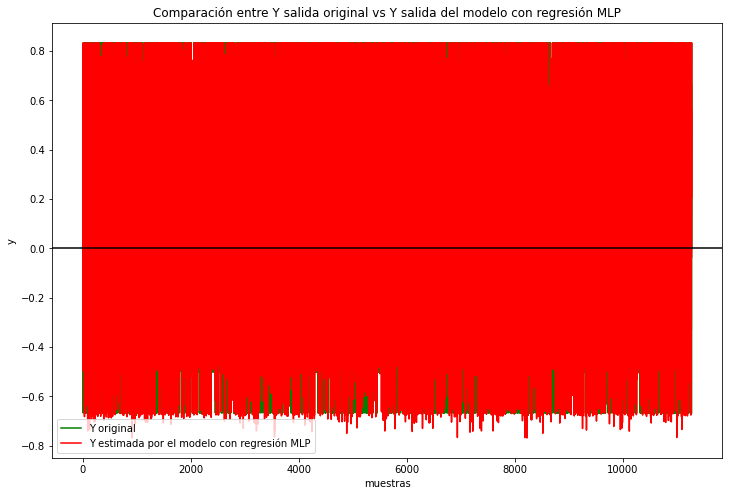

In [59]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']

grafica_mejor(url, (100,2))

## Grandes

In [60]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/mlp_regressor.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data
      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
        layers = [(100, 1), (100, 2)]

        for opc in layers:
          MLPR = MLPRegressor(random_state=1, max_iter=200, hidden_layer_sizes=opc, learning_rate='adaptive', learning_rate_init=0.01)
          MLPR.fit(X_Entrenamiento, Y_Entrenamiento)

          Y_pred = MLPR.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, MLPR, filename)
          result['CONFIG'] = '_'.join(str(v) for v in opc)
          df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [61]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
5,min_max_original.csv,100_2,0.966476,-0.000034,0.000010,0.958612,0.011125,0.966929,0.001665,0.008123,2.429899
57,min_max_lof_euclidean_5.csv,100_2,0.957178,-0.000048,0.000015,0.952129,0.030739,0.957374,0.001735,0.008616,2.434258
59,min_max_lof_minkowski_5.csv,100_2,0.957178,-0.000048,0.000015,0.952129,0.030739,0.957374,0.001735,0.008616,2.434258
71,min_max_lof_minkowski_9.csv,100_2,0.953891,-0.000041,0.000010,0.936089,0.031918,0.954609,0.002300,0.008761,2.348388
69,min_max_lof_euclidean_9.csv,100_2,0.953891,-0.000041,0.000010,0.936089,0.031918,0.954609,0.002300,0.008761,2.348388
79,min_max_lof_manhattan_11.csv,100_2,0.955665,-0.000047,0.000022,0.959485,0.021738,0.959003,0.002625,0.006731,2.141868
61,min_max_lof_manhattan_5.csv,100_2,0.948000,-0.000036,0.000016,0.956037,0.014300,0.965530,0.004125,0.008946,2.536267
77,min_max_lof_minkowski_11.csv,100_2,0.939281,-0.000040,0.000014,0.946446,0.025950,0.960826,0.004612,0.005117,1.866019
75,min_max_lof_euclidean_11.csv,100_2,0.939281,-0.000040,0.000014,0.946446,0.025950,0.960826,0.004612,0.005117,1.866019
63,min_max_lof_euclidean_7.csv,100_2,0.925879,-0.000044,0.000009,0.952284,0.019747,0.953829,0.005521,0.006031,2.083448


### Mejor resultado

In [62]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
5,min_max_original.csv,100_2,0.966476,-0.000034,0.00001,0.958612,0.011125,0.966929,0.001665,0.008123,2.429899


46.37318994517648


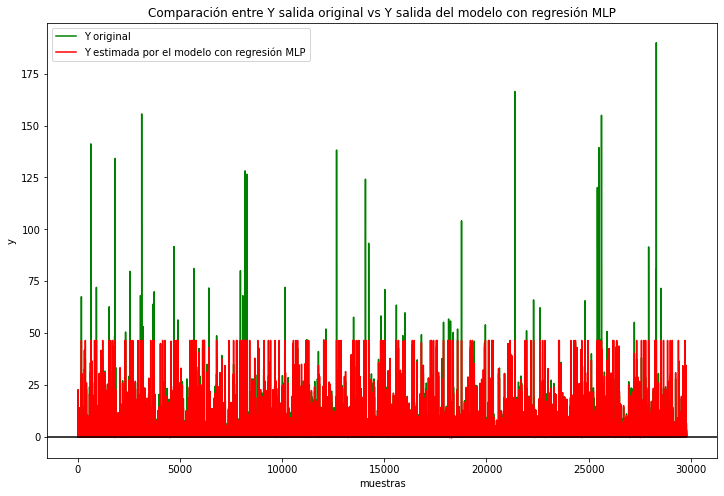

In [69]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']

grafica_mejor(url, (100,2))